test 4D optimisation with multi-task initialisation data

use branch `multi-task` to run this notebook!

In [1]:
import numpy as np
from boss.bo.bo_main import BOMain

In [2]:
import matplotlib.pyplot as plt

In [3]:
seed=123
init='random' # 'sobol' or 'random'
num_iter = 150
num_support_data = 500

utilities:

In [4]:
import GPy

In [5]:
def load_model(filename):

    # load saved data
    saved=np.load(filename)
    dim=saved['X'].shape[1]

    # create kernel
    k=GPy.kern.StdPeriodic(input_dim=dim,ARD1=True,ARD2=True)

    # create mean function
    mf=GPy.mappings.Constant(dim,1)

    # create model
    m=GPy.models.GPRegression(saved['X'],saved['Y'],kernel=k,mean_function=mf)

    # set model params
    m[:]=saved['params']
    m.fix()
    m.parameters_changed()

    return m

optimisation task:

In [6]:
def f_0(x):
    return unknown_model_0.predict(np.atleast_2d(x))[0]

def f_1(x):
    return unknown_model_1.predict(np.atleast_2d(x))[0]

In [7]:
unknown_model_0=load_model('../models/model_4D_E0.npz')
unknown_model_1=load_model('../models/model_4D_E1.npz')

In [8]:
bounds=[[-50.0, 310.0]]*4
bounds[1]=[-50.0, 70] # second dimension has 1/3 period

expected minima, from baseline optimisation notebook:

In [9]:
expected_minimum_1 = [236, 55, 62, 0]
expected_minimum_0 = [57, 62, 205, 180]

evaluate:

In [10]:
[f_1(expected_minimum_1)[0][0], f_1(expected_minimum_0)[0][0]]

[-8803.279879669186, -8803.227138304028]

In [11]:
[f_0(expected_minimum_1)[0][0], f_0(expected_minimum_0)[0][0]]

[20.6422851531129, 15.79385270994819]

plot at expected minimum 1:

In [12]:
def plot_slices(f, xp, plot_point, levels=25):
    x1, x2 = np.meshgrid(xp,xp)
    dim = len(plot_point)
    for dim1 in range(dim-1):
        for dim2 in range(dim-dim1-1):
            plt.subplot(dim-1,dim-1,dim*dim1+dim2+1)
            plot_input = np.tile(plot_point,(len(xp)*len(xp),1))
            plot_input[:,dim1] = x1.ravel()
            plot_input[:,dim1+dim2+1] = x2.ravel()
            yp = f(plot_input)
            cset = plt.contour(xp, xp, yp.reshape(len(xp),len(xp)), levels=levels)
            plt.colorbar(cset)
            plt.xlabel('dim {}'.format(dim1+1))
            plt.ylabel('dim {}'.format(dim1+dim2+2))

In [13]:
xp = np.linspace(-50, 310, 181)

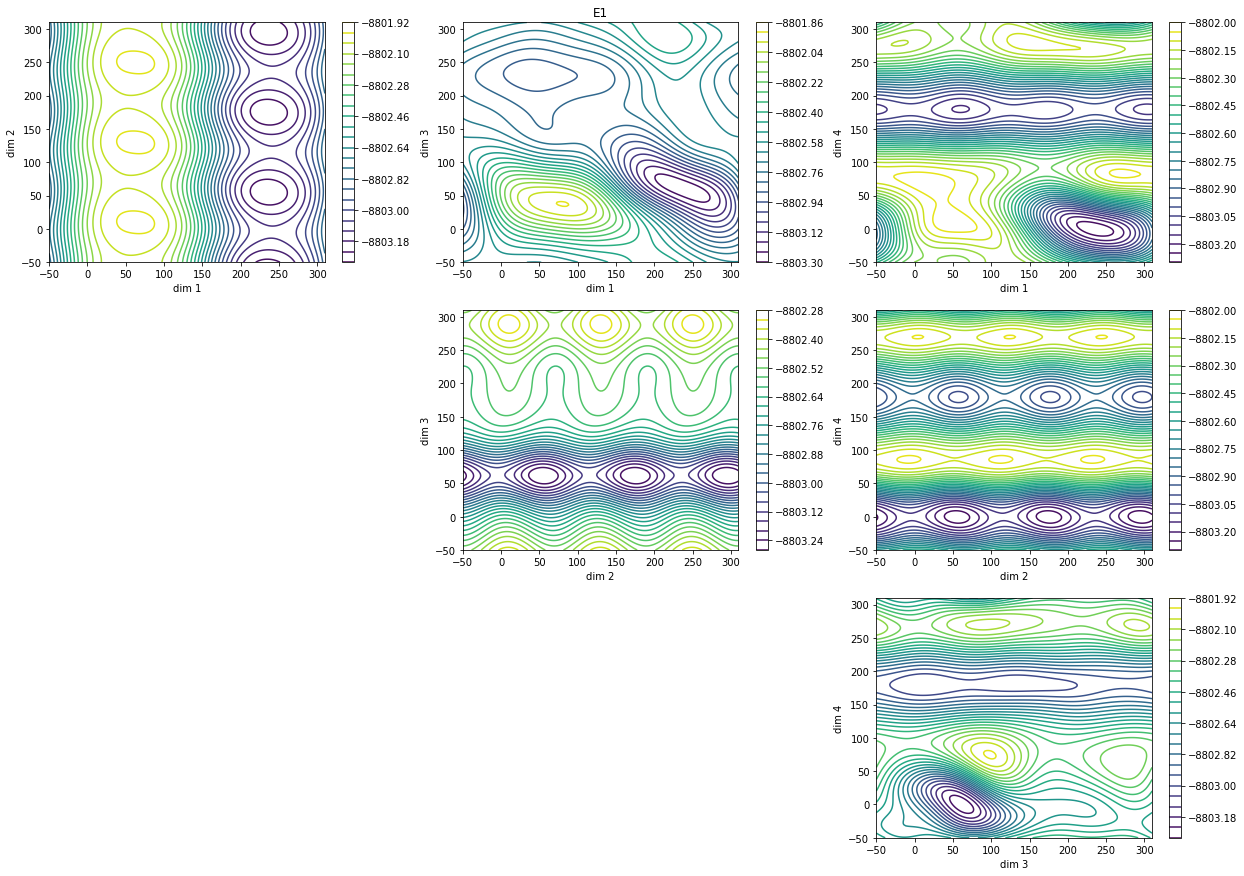

In [14]:
plt.figure(figsize=(3*7,3*5))
plot_slices(f_1, xp, expected_minimum_1)
plt.subplot(3,3,2)
plt.title('E1');

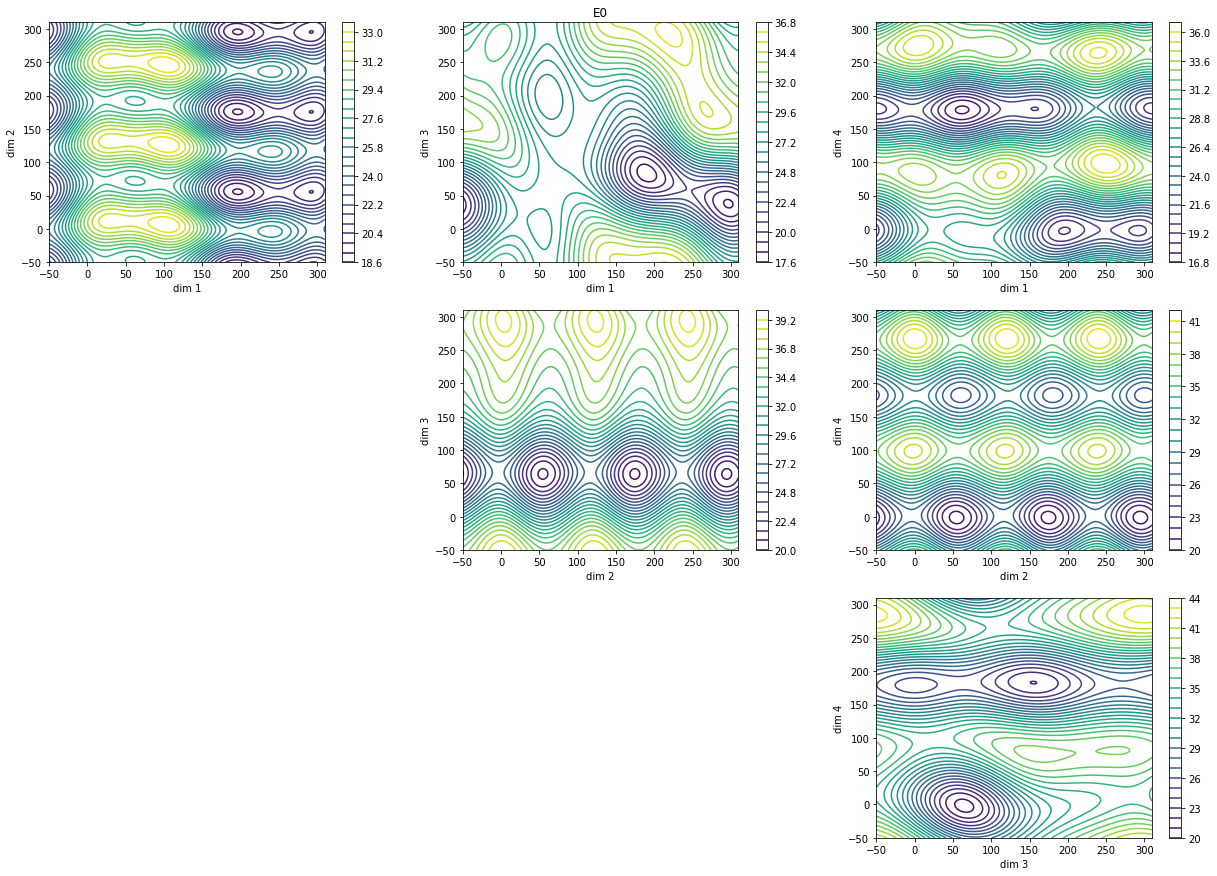

In [15]:
plt.figure(figsize=(3*7,3*5))
plot_slices(f_0, xp, expected_minimum_1)
plt.subplot(3,3,2)
plt.title('E0');

## baseline optimisation

In [16]:
bo_1 = BOMain(
    f_1, 
    bounds,
    yrange=[0, 1],
    kernel='stdp',
    inittype=init,
    initpts=5,
    iterpts=num_iter,
    seed=seed
)

In [17]:
%time res_1 = bo_1.run()

CPU times: user 10min 8s, sys: 51.1 s, total: 10min 59s
Wall time: 7min 45s


In [18]:
[res_1.xbest, res_1.ybest]

[array([233.87662674,  48.4058633 ,  57.48399567,   3.00192622]),
 -8803.270136563224]

In [19]:
[res_1.xmin, res_1.fmin]

[array([242.73261489,  41.51875842,  60.17048542,   7.13180248]),
 -8803.30307591153]

evaluate optimisation outcome:

In [20]:
f_1(res_1.xmin)

array([[-8803.24085773]])

## optimisation with multi-task initialisation data

In [21]:
bo_2 = BOMain(
    [f_1, f_0], 
    bounds,
    num_tasks=2,
    kernel='stdp',
    inittype=init,
    initpts=[5, num_support_data],
    iterpts=num_iter,
    seed=seed
)

In [22]:
%time res_2 = bo_2.run()

CPU times: user 1h 33min 36s, sys: 13min 24s, total: 1h 47min 1s
Wall time: 1h 33min 23s


In [23]:
[res_2.xbest, res_2.ybest]

[array([224.70719641,  51.96014521,  63.91009462,   4.93234364]),
 -8803.27135123775]

In [24]:
[res_2.xmin, res_2.fmin]

[array([ 2.23378276e+02,  5.47553768e+01,  6.72367048e+01, -6.92788413e-02]),
 -8803.27930361412]

evaluate optimisation outcome:

In [25]:
f_1(res_2.xmin)

array([[-8803.27685445]])

estimated variances and covariance between tasks:

In [26]:
bo_2.model.get_task_covariance()

array([[  1.38870755,   6.12642815],
       [  6.12642815, 140.62910154]])

compare:

In [27]:
estimated_mins_1 = [conv_res[2] for conv_res in res_1.convergence]
fmin_1 = f_1(np.array(estimated_mins_1))

In [28]:
estimated_mins_2 = [conv_res[2] for conv_res in res_2.convergence]
fmin_2 = f_1(np.array(estimated_mins_2))

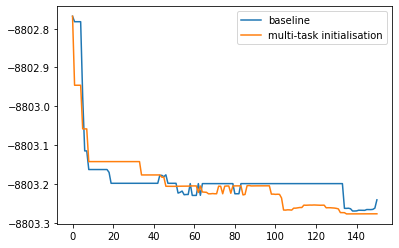

In [29]:
plt.plot(np.arange(bo_1.iterpts+1), fmin_1, label='baseline')
plt.plot(np.arange(bo_2.iterpts+1), fmin_2, label='multi-task initialisation')
plt.legend();

see model params:

In [30]:
bo_1.model.get_all_params()

{'noise': 1e-12,
 'variance': 0.10183756920304679,
 'lengthscales': [0.7683733158218363,
  2.4760453435688574,
  0.8600117350365183,
  0.45500563818387263],
 'periods': [360.0, 120.0, 360.0, 360.0]}

In [31]:
bo_2.model.get_all_params()

{'noise': [1e-12, 1e-12],
 'lengthscales': [0.980205101088392,
  6.984995053522111,
  1.1384748458088207,
  1.1077714212863148],
 'periods': [360.0, 120.0, 360.0, 360.0],
 'kappa': array([0.73470181, 0.01031919]),
 'W': array([[0.43641671],
        [0.3807922 ]])}

prior distributions were studied in sten 2021 http://urn.fi/URN:NBN:fi:aalto-202101311714

test optimisation with the recommended setup:

In [32]:
base_rate = 2/0.5**2

In [33]:
W_prior='gaussian'
W_mean = 0.9 * np.sqrt(2 / base_rate)
W_std = 0.5 / np.sqrt(base_rate)

In [34]:
bo_3 = BOMain(
    [f_1, f_0], 
    bounds,
    num_tasks=2,
    kernel='stdp',
    inittype=init,
    initpts=[5, num_support_data],
    iterpts=num_iter,
    seed=seed,
    W_prior=W_prior,
    W_priorpar=[W_mean, W_std]
)

In [35]:
%time res_3 = bo_3.run()

CPU times: user 1h 58min 13s, sys: 18min 2s, total: 2h 16min 16s
Wall time: 2h 11min 19s


In [36]:
[res_3.xbest, res_3.ybest]

[array([232.52036047,  53.11998157,  65.52122091,  -1.14785066]),
 -8803.278248729279]

In [37]:
[res_3.xmin, res_3.fmin]

[array([232.13383106,  55.17180214,  65.44647707,  -1.32606833]),
 -8803.27876237965]

In [38]:
f_1(res_3.xmin)

array([[-8803.27898529]])

In [39]:
bo_3.model.get_all_params()

{'noise': [1e-12, 1e-12],
 'lengthscales': [0.9854319458710363,
  6.998167606748335,
  1.114264936933159,
  1.100928564894564],
 'periods': [360.0, 120.0, 360.0, 360.0],
 'kappa': array([1.36848080e+00, 8.42436768e-06]),
 'W': array([[0.54017887],
        [0.38611343]])}

compare:

In [40]:
estimated_mins_3 = [conv_res[2] for conv_res in res_3.convergence]
fmin_3 = f_1(np.array(estimated_mins_3))

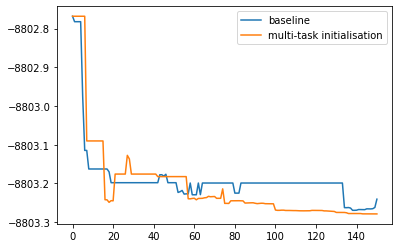

In [41]:
plt.plot(np.arange(bo_1.iterpts+1), fmin_1, label='baseline')
plt.plot(np.arange(bo_3.iterpts+1), fmin_3, label='multi-task initialisation')
plt.legend();